In [1]:
!pip install nltk seaborn

In [2]:
# Import necessary libraries & Preprocessing Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<[^>]+>', '', str(text))
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
# Load your CSV
df = pd.read_csv("Laptop_Product_Reviews (1).csv")

# View columns
print(df.columns)

# Add a dummy label column for now (random 0 or 1)
import numpy as np
df['label'] = np.random.randint(0, 2, df.shape[0])  # 0 = negative, 1 = positive

# Proceed with EDA
print(df['label'].value_counts())

Index(['Product Name', 'Review Text'], dtype='object')
label
1    2540
0    2460
Name: count, dtype: int64


EDA

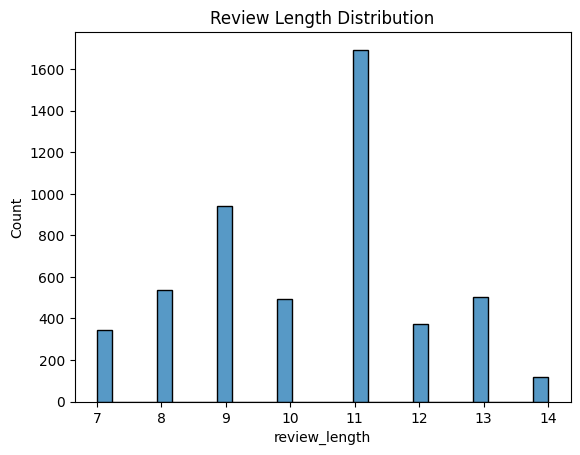

In [6]:
# EDA
df['review_length'] = df['Review Text'].apply(lambda x: len(str(x).split()))
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['review_length'])
plt.title("Review Length Distribution")
plt.show()

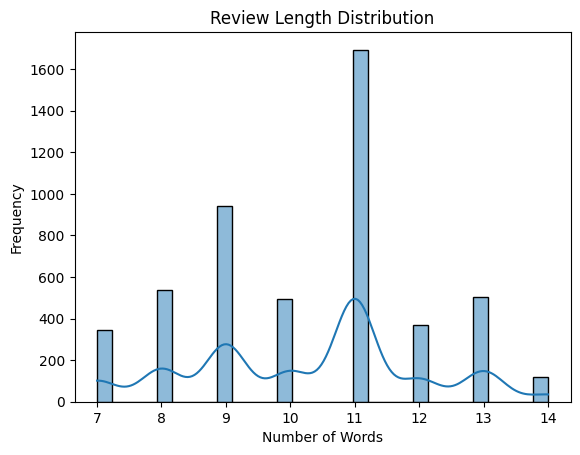

In [7]:
# Calculate review length (number of words)
df['review_length'] = df['Review Text'].apply(lambda x: len(str(x).split()))

# Plot histogram
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [8]:
# Check for missing values
print(df.isnull().sum())

# Drop nulls
df.dropna(inplace=True)

# Check for duplicates
print("Duplicates:", df.duplicated().sum())

# Drop duplicates
df.drop_duplicates(inplace=True)

Product Name     0
Review Text      0
label            0
review_length    0
dtype: int64
Duplicates: 4916


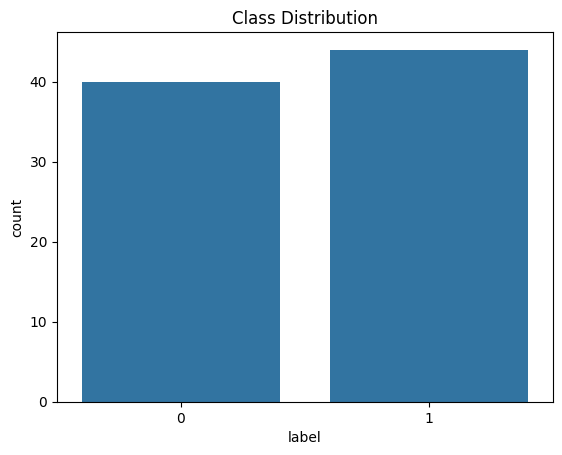

In [9]:
import numpy as np

# Dummy label for now: Random 0 or 1 (0 = negative, 1 = positive)
np.random.seed(42)  # For reproducibility
df['label'] = np.random.randint(0, 2, df.shape[0])

# Check balance
sns.countplot(x='label', data=df)
plt.title("Class Distribution")
plt.show()

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<[^>]+>', '', str(text))                     # Remove HTML
    text = re.sub(r'[^a-zA-Z\s]', '', text)                      # Remove non-letters
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

# Apply cleaning
df['cleaned_review'] = df['Review Text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
# saving cleaned data
df.to_csv("/content/cleaned_reviews.csv", index=False)
df.head()

,Product Name,Review Text,label,review_length,cleaned_review
0,HP Pavilion 15 Laptop,The performance is acceptable for basic office...,0,14,performance acceptable basic office work suite...
1,HP Pavilion 15 Laptop,"The keyboard is comfortable to type on, and th...",1,13,keyboard comfortable type trackpad responsive
2,HP Pavilion 15 Laptop,"The laptop stays cool during extended use, whi...",0,12,laptop stay cool extended use huge plus
3,HP Pavilion 15 Laptop,Boot time is quick thanks to the SSD storage.,0,9,boot time quick thanks ssd storage
4,HP Pavilion 15 Laptop,Boot time is slower than expected despite havi...,0,10,boot time slower expected despite ssd storage


LSTM Model

In [12]:
# Imports for model building
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [13]:
# Load the cleaned CSV
df = pd.read_csv("/content/cleaned_reviews.csv")
print(df.columns)
texts = df['cleaned_review']
labels = df['label']

Index(['Product Name', 'Review Text', 'label', 'review_length',
       'cleaned_review'],
      dtype='object')


In [14]:
# tokenisation and padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

texts = df['cleaned_review']
labels = df['label']

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=100)

In [15]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.1, random_state=42
)


In [16]:
# train LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 514ms/step - accuracy: 0.4872 - loss: 0.6927 - val_accuracy: 0.4444 - val_loss: 0.6921
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.5334 - loss: 0.6870 - val_accuracy: 0.4444 - val_loss: 0.6977
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.5206 - loss: 0.6837 - val_accuracy: 0.4444 - val_loss: 0.7004
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.5049 - loss: 0.6797 - val_accuracy: 0.4444 - val_loss: 0.7044
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.5284 - loss: 0.6707 - val_accuracy: 0.4444 - val_loss: 0.7147


In [17]:
# evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert to class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


In [18]:
# accuracy
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# Precision, recall, F1-score
print(classification_report(y_test, y_pred))

✅ Accuracy: 0.4444444444444444
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.44      1.00      0.62         4

    accuracy                           0.44         9
   macro avg       0.22      0.50      0.31         9
weighted avg       0.20      0.44      0.27         9



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


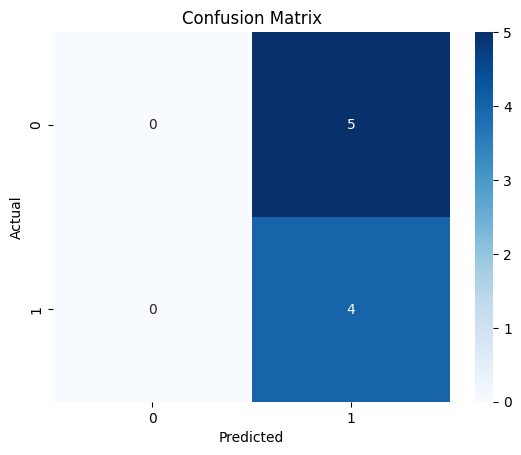

In [19]:
# confusion matrix plot
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
# 2
from sklearn.model_selection import train_test_split

In [21]:
# Use cleaned review text and labels
texts = df['cleaned_review']
labels = df['label']

In [22]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=100)

# 70-30 split
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.3, random_state=42
)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [24]:
#Rebuild and Train the LSTM

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 858ms/step - accuracy: 0.5553 - loss: 0.6926 - val_accuracy: 0.5385 - val_loss: 0.6923
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step - accuracy: 0.5647 - loss: 0.6873 - val_accuracy: 0.5385 - val_loss: 0.6914
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - accuracy: 0.5219 - loss: 0.6832 - val_accuracy: 0.5385 - val_loss: 0.6908
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.5011 - loss: 0.6794 - val_accuracy: 0.5385 - val_loss: 0.6903
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.5761 - loss: 0.6706 - val_accuracy: 0.5385 - val_loss: 0.6898


In [25]:
#evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# Predict and round probabilities
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


In [27]:
# Accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.5384615384615384

 Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.54      1.00      0.70        14

    accuracy                           0.54        26
   macro avg       0.27      0.50      0.35        26
weighted avg       0.29      0.54      0.38        26



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


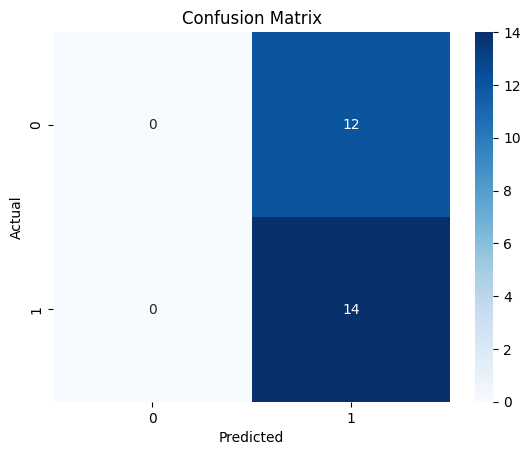

In [28]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()